<a href="https://colab.research.google.com/github/So-nja/Keras_example_study_2023/blob/main/Computer_Vision/Image_classification_with_Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vision Transformer를 이용한 이미지 분류 - 뒷부분 추가중

*이 문서는 keras 예제를 분석하여 해설을 작성한 것입니다.*

<br>[예제 페이지](https://keras.io/examples/vision/image_classification_with_vision_transformer/)
<br>[발표논문 : An Image is Worth 16x16 Words](https://arxiv.org/abs/2010.11929)

<br>
<br>
이 문서에서는 Alexey Dosovitskiy et al의 Vision Transformer(VIT)를 구현해본다. <br>
CIFAR -100 dataset을 사용하였다. <br>
Vit 모델은 self-attention을 사용하는 트랜스포머 구조를 이미지 패치라는 시퀀스에 적용한 것으로, 기존의 convolution layer를 사용하지 않는다. 
<br><br>
이 예제는 TensorFlow 2.4 이상과 TensorFlow Addons를 필요로 하므로 아래와 같은 명령어를 사용해 설치하도록 한다.

In [1]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.3 MB/s eta 0:00:00


#Setup & Prepare the data

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [3]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169001437/169001437 [==============================] - 13s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


#Configure the hyperparameters

In [4]:
learning_rate = 0.001
weight_decay = 0.0001   #가중치 감소 : 특정값을 손실함수에 더해주는 것. 
#커질수록 가중치 값이 작아지고 오버피팅 현상을 해소할 수 있지만, 이 값이 너무 크면 언더피팅이 발생
batch_size = 256
num_epochs = 100
image_size = 72  # 입력 이미지를 리사이즈즈
patch_size = 6  # 입력 이미지에 적용할 패치 사이즈
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

#Use data augmentation

[Keras 전처리층 다루기 - 참고페이지](https://www.kaggle.com/code/daddy321/preprocessing-layers-ko-ver-tf-guide)

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(x_train)

#Implement multilayer perceptron (MLP)

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)   #활성화 함수는 gelu
        x = layers.Dropout(dropout_rate)(x)
    return x

#Implement patch creation as a layer

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

샘플 이미지를 출력하도록 한다. 

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


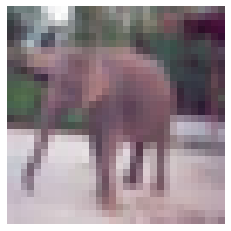

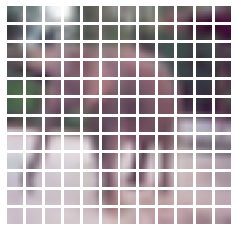

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

추후 추가 